In [1]:
from itertools import count

from coherentagents_basic_py import *

# Define plotting functions

In [2]:
def plot_example_agents(results, n):
    fig, axes = plt.subplots(int(n/5),5, figsize=(16,6), sharex=True, sharey=True)
    n_agents = len(results.loc[results["t"]==0])
    for n, ax in zip(np.random.choice(range(n_agents), size=10), axes.flatten()):
        results.loc[n].plot(x="t", ax=ax, legend=False)
        ax.set_ylim(-1.1,1.1)
        ax.grid()
        ax.set_title("agent {} (group {})".format(n, results.loc[n]["group"].iloc[0]))
    axes[0,0].legend()
    fig.suptitle("Opinion dynamics of example agents ")
    fig.tight_layout()
    return

In [117]:
def plot_group_dynamics(res, param, dim1, dim2, fuzz=0.05):
    attitude_names = res.columns[0:5]
    groups = np.sort(np.unique(res["group"]))
    cmap = copy.copy(plt.get_cmap("Set1"))
    colors = [cmap(g) for g in groups]
    mapping = dict(zip(groups, colors))
    
    fig, axes = plt.subplots(4,len(groups), sharey="row", figsize=(16,13))
    for ax, g in zip(axes[0,:], groups):
        a = res.where(res["group"]==g).dropna()
        a_x = a.groupby("t").mean()
        a_x_items = a_x[res.columns[0:5]]
        a_x_items.plot(ax=ax, legend=False)
        ax.set_title("group {}".format(g))
    axes[0,0].legend()
    
    # 2
    m = Model(**param, save_network=False)
    for n, ax in enumerate(axes[1,:]):
        ax.imshow(np.tril(m.matrix_list[n]), vmin=-1, vmax=1,cmap="bwr")
        ax.set_xticks(range(5))
        ax.set_xticklabels(attitude_names, rotation=45)
    axes[1, -1].set_yticks(range(5))
    axes[1,-1].set_yticklabels(attitude_names)
    axes[1,-1].yaxis.tick_right()

    # 3
    for n, t in enumerate([0,200]):
        for ax, g in zip(axes[n+2,:], groups):
            r2 = res.where(res["group"]==g).dropna()
            r = r2.loc[r2["t"]==t]
            #groups = r["group"]
            xvals = r[dim1] - fuzz/2+ np.random.random(size=len(r[dim1])) * fuzz
            yvals = r[dim2] - fuzz/2+ np.random.random(size=len(r[dim2])) * fuzz

            ax.scatter(xvals, yvals, color=mapping[g], s=5)
            ax.set_ylim(-1.05,1.05)
            ax.set_xlim(-1.05,1.05)
            ax.set_xlabel(dim1)
            ax.set_ylabel(dim2)
            ax.set_title("time {}".format(t))
            print("group: {} --> #={}".format(g, len(xvals)), end=", ")
            

    fig.tight_layout()
    return mapping

In [113]:
def plot_before_after_hist(results, T):
    attitude_names = results.columns[0:5]
    n_bins = {
        "freehms": 5,
        "gincdif": 5,
        "lrscale": 11,
        "euftf": 11,
        "impcntr": 4
    }
    bins = {}
    for a in attitude_names:
        bins[a] = np.linspace(-1-np.diff(np.linspace(-1,1,n_bins[a]))[0]/2, 1+np.diff(np.linspace(-1,1,n_bins[a]))[0]/2, n_bins[a]+1)
    fig, axes = plt.subplots(1,5, figsize=(16,4), sharex=False, sharey=True)
    for t, col in zip([0,T], ["k", "blue"]):
        curr_results = results.loc[results["t"]==t]
        for ax, a in zip(axes, attitude_names):
            curr_results[a].plot.hist(ax=ax, bins=bins[a], width=np.diff(bins[a])[0]*0.8, align="mid", alpha=0.5,color=col, label="time {}".format(t))
            if len(bins[a])>6:
                ax.set_xticks(bins[a][:-1][::2]+np.diff(bins[a])[0]/2)
                ax.set_xticklabels(["{:.2f}".format(u) for u in ax.get_xticks()])
            else:
                ax.set_xticks(bins[a][:-1]+np.diff(bins[a])[0]/2)
                ax.set_xticklabels(["{:.2f}".format(u) for u in ax.get_xticks()])
            ax.set_xlabel(a)
    axes[0].legend()


In [114]:
def vis_state(ax, results, dim1, dim2, t, fuzz=0.1):
    r = results.loc[results["t"]==t]
    groups = r["group"]
    xvals = r[dim1] - fuzz/2+ np.random.random(size=len(r[dim1])) * fuzz
    yvals = r[dim2] - fuzz/2+ np.random.random(size=len(r[dim2])) * fuzz
    cmap = copy.copy(plt.get_cmap("Set1"))
    colors = [cmap(g) for g in groups]
    ax.scatter(xvals, yvals, color=colors)
    ax.set_ylim(-1.05,1.05)
    ax.set_xlim(-1.05,1.05)
    ax.set_xlabel(dim1)
    ax.set_ylabel(dim2)
    ax.set_title("Time {}".format(t))
    ax.set_aspect("equal")
    
def compare_states(results, t1,t2, dim1, dim2):
    fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
    vis_state(axes[0], results, dim1, dim2, t1)
    vis_state(axes[1], results, dim1, dim2, t2)



In [6]:
def vis_network(results_nw, results, t, pos = None):
    a = results_nw.where(results_nw["t"]==t).dropna().drop(columns="t")
    n_edges = len(a)
    G = nx.from_pandas_edgelist(a, source="source", target="target", edge_attr="health")
    b = results.where(results["t"]==t).dropna().drop(columns="t")
    nx.set_node_attributes(G, dict(zip(G.nodes, b.group.to_numpy())),name="group")
    groups = np.unique(results.group)
    nodes = G.nodes()
    colors = [G.nodes[n]['group'] for n in nodes]
    # drawing nodes and edges separately so we can capture collection for colobar
    plt.figure(figsize=(16,9))
    pos = nx.spring_layout(G) if not pos else pos
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                                node_size=6, cmap=plt.get_cmap("Set1"))
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    return pos

# SIMULATIONS

In [7]:
T = 200
track_times = np.arange(0,T+1,step=10)
default_params = dict(
        rand_seed=42, 
        network_type = "watts",
        network_params={"rewiring_prob":0.1, "avg_node_degree":10}, 
        country="DE", 
        n_attitudes = 5,
        k_coherence=100,
        k_link=-100, 
        conformity_tendency = 0.2,
        variance_of_new_belief = 0.0,
        prob_social_influence = 0.0,
        prob_self_check = 0.0,
        link_health_change = 0.0,
        max_prob_drop_bad_link = 0.0,
        prob_FoF = 0.0,
        version = "coherence_MB_v2_BE_2.2",
        prob_add_link = 0.0,
        link_lonely = False,
        max_num_links = 1000,
        init_beliefs="from_data",
)

### Run with only social influence process
- fixed WS-network
- no self-coherence/reflection process

In [8]:
params1 = copy.copy(default_params)
params1["prob_social_influence"]=1.0
elapsed_time, results_1, results_network_1 = simulation(T, track_times, params1, verbose=False, save_network=True)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 



elapsed time: 1 min and 25.7 seconds (i.e. 0.4287288057804108 s per tick)


In [9]:
results_1.head()

item,freehms,gincdif,lrscale,impcntr,euftf,group,t
0,0.5,0.5,0.0,1.000000,0.8,1,0
1,1.0,1.0,0.0,1.000000,0.6,3,0
2,1.0,1.0,-0.4,1.000000,0.6,2,0
3,-0.5,0.5,-0.6,0.333333,0.2,4,0
4,1.0,1.0,0.0,1.000000,0.6,3,0


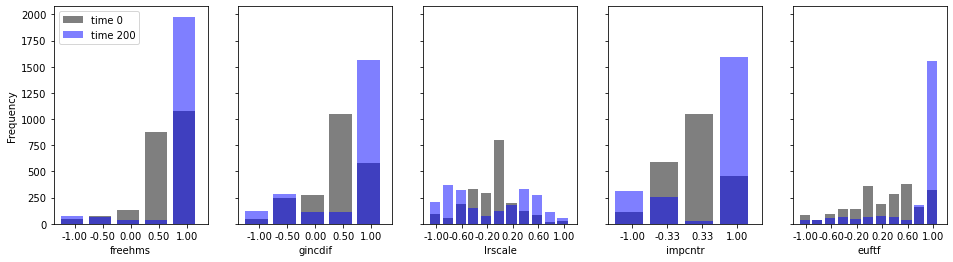

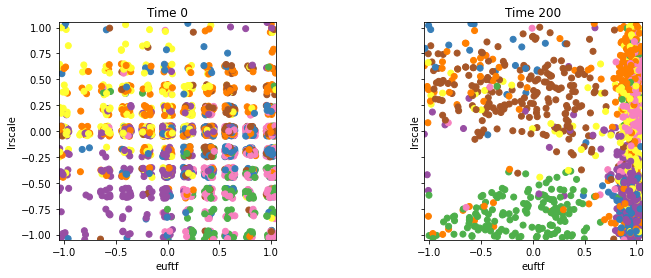

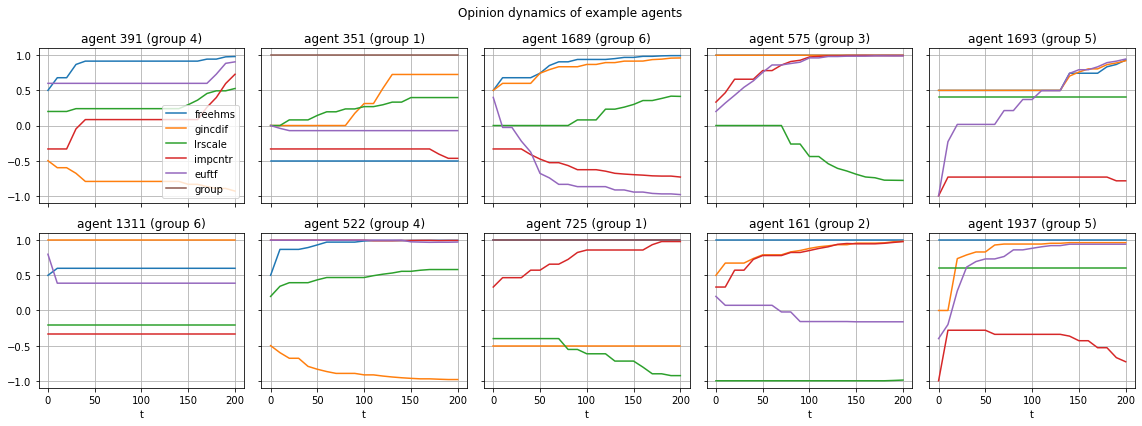

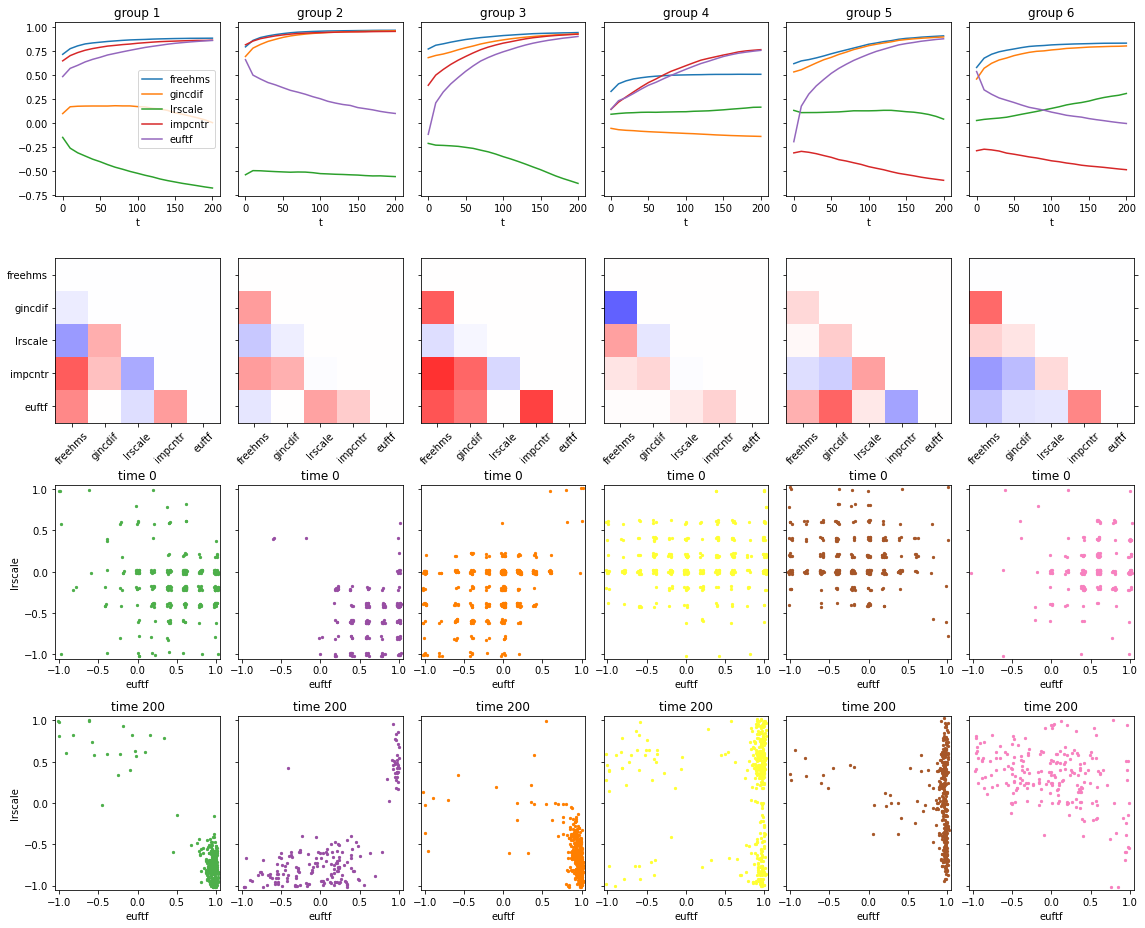

In [11]:
plot_before_after_hist(results_1, T=T)
compare_states(results_1, 0, T, "euftf", "lrscale")
plot_example_agents(results_1, 10)
plot_group_dynamics(results_1, params1, "euftf", "lrscale")


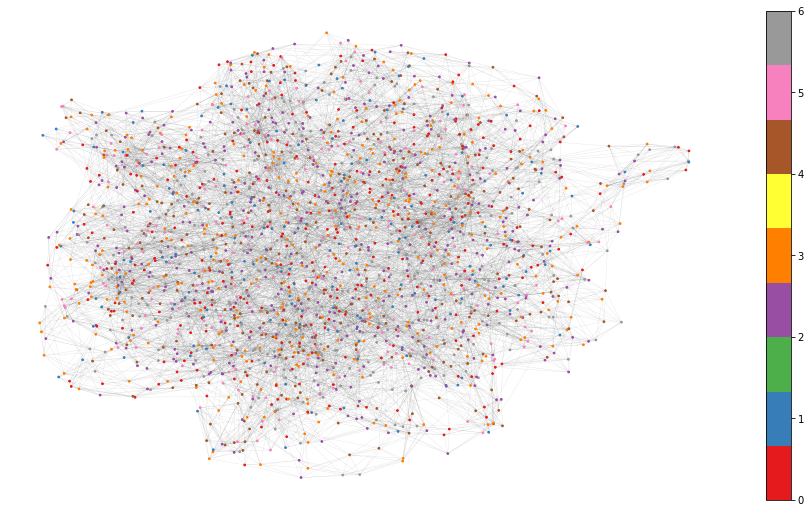

In [20]:
# RUN THIS ONLY IF YOU HAVE SOME TIME
vis_network(results_network_1, results_1, 200)

### Only self-coherence
- fixed social network
- no social influence


In [12]:
T = 1000
track_times = np.arange(0,T+1,step=20)
params2 = copy.copy(default_params)
params2["prob_self_check"] = 1
params2["variance_of_new_belief"] = 0.3
elapsed_time, results_selfCheck, results_network_selfCheck = simulation(T, track_times, params2, save_network=True, verbose=False)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 

elapsed time: 2 min and 16.0 seconds (i.e. 0.13602037501335143 s per tick)


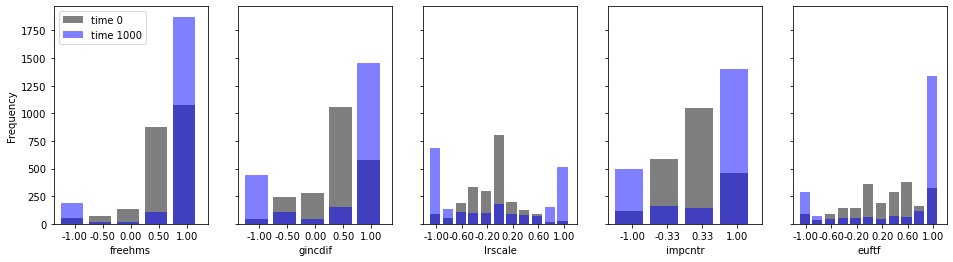

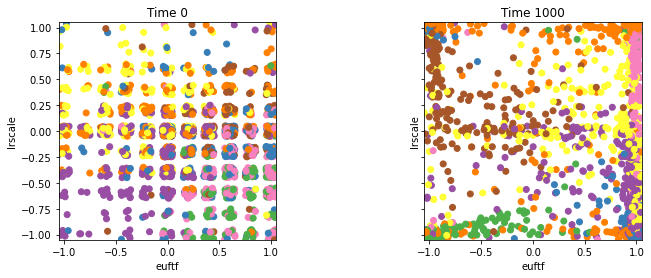

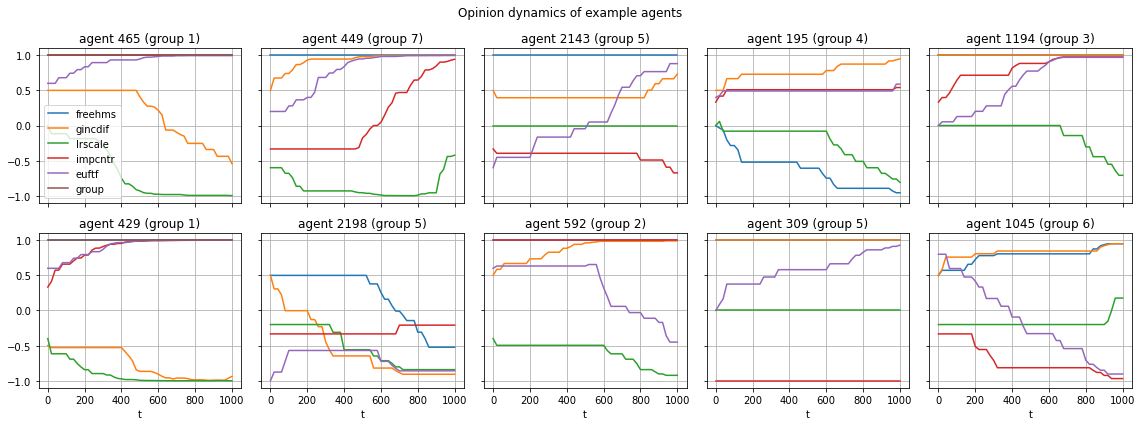

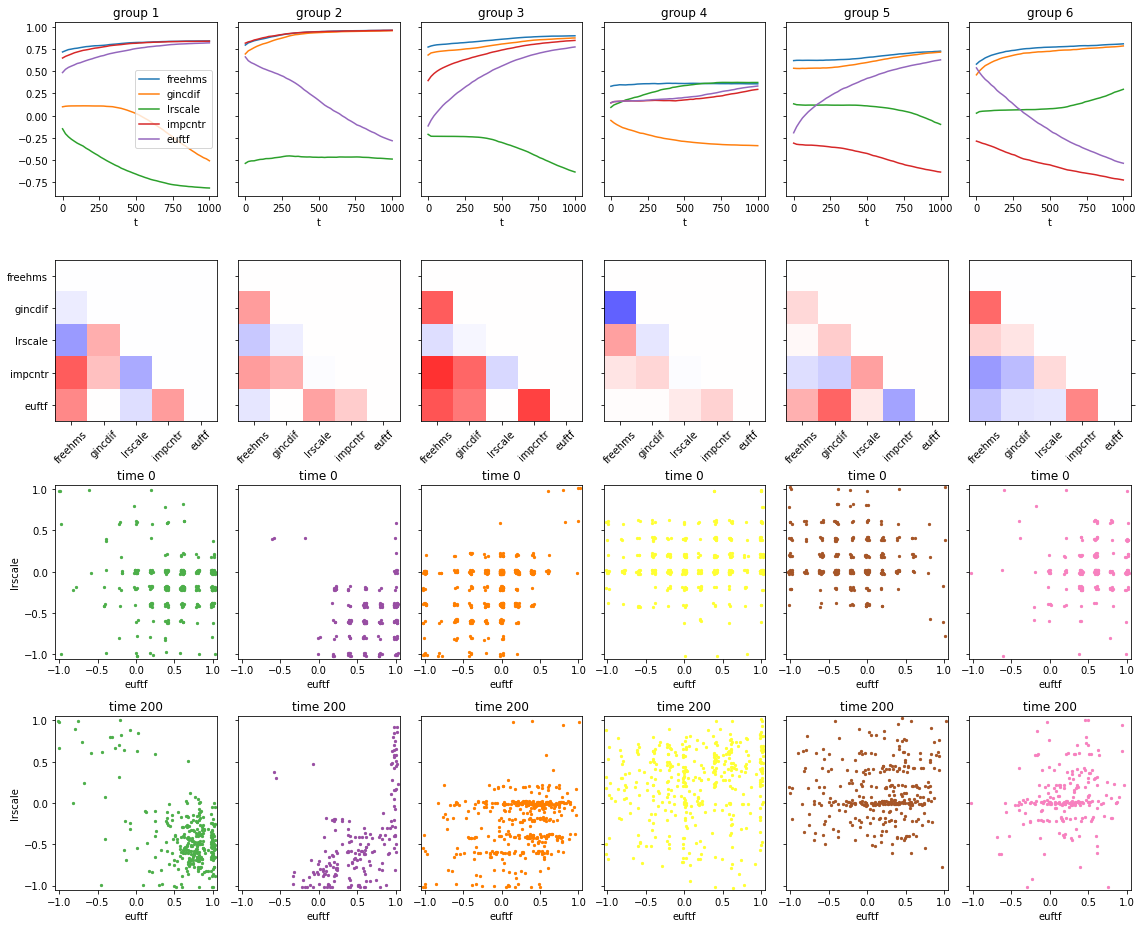

In [13]:
plot_before_after_hist(results_selfCheck, T=T)
compare_states(results_selfCheck, 0, T, "euftf", "lrscale")
plot_example_agents(results_selfCheck, 10)
plot_group_dynamics(results_selfCheck, params2, "euftf", "lrscale")


In [14]:
T=200
track_times = np.arange(0,T+1,step=10)

### Mixed: Social influence + self-coherence
- fixed social network
- some social influence and self-check
- strong coherence dependency

In [15]:
params3 = copy.copy(default_params)
params3["prob_social_influence"] = 0.5
params3["prob_self_check"] = 1
params3["variance_of_new_belief"] = 0.1

elapsed_time, results_mix, results_network_mix = simulation(T, track_times, params3, verbose=False, save_network=True)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 


elapsed time: 1 min and 2.5 seconds (i.e. 0.31266002655029296 s per tick)


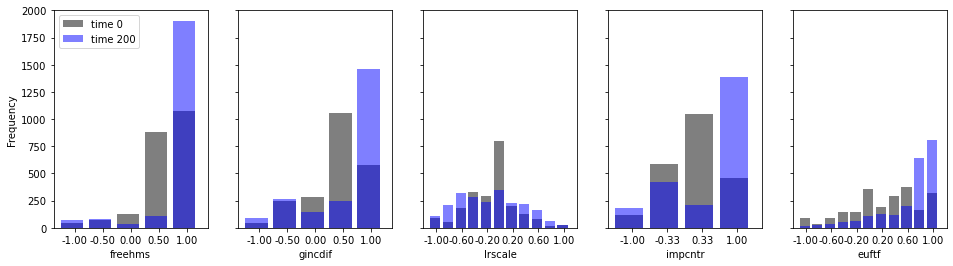

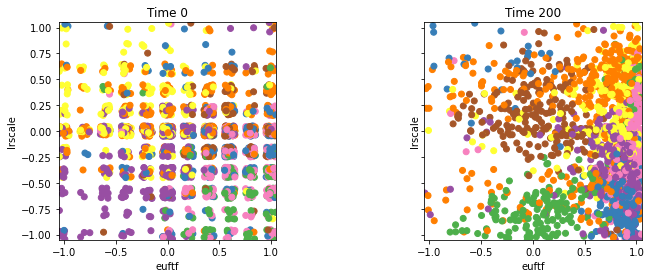

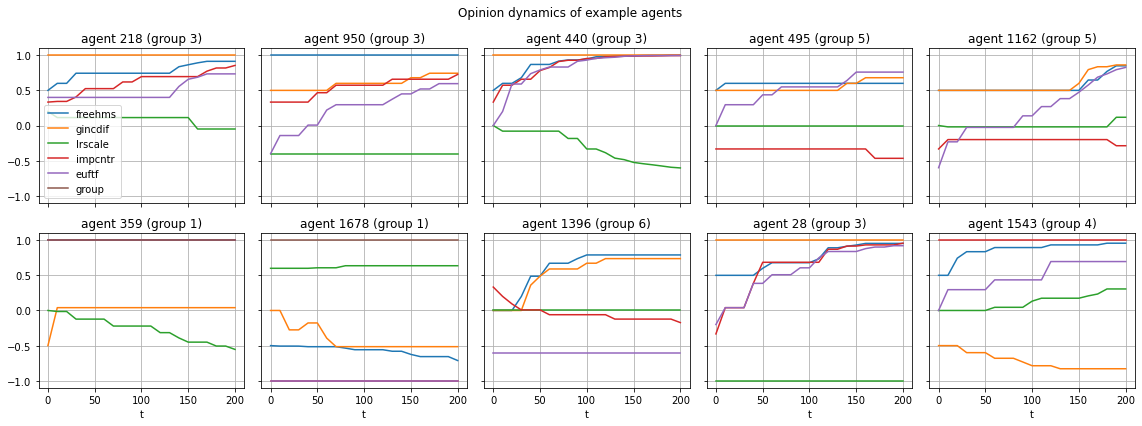

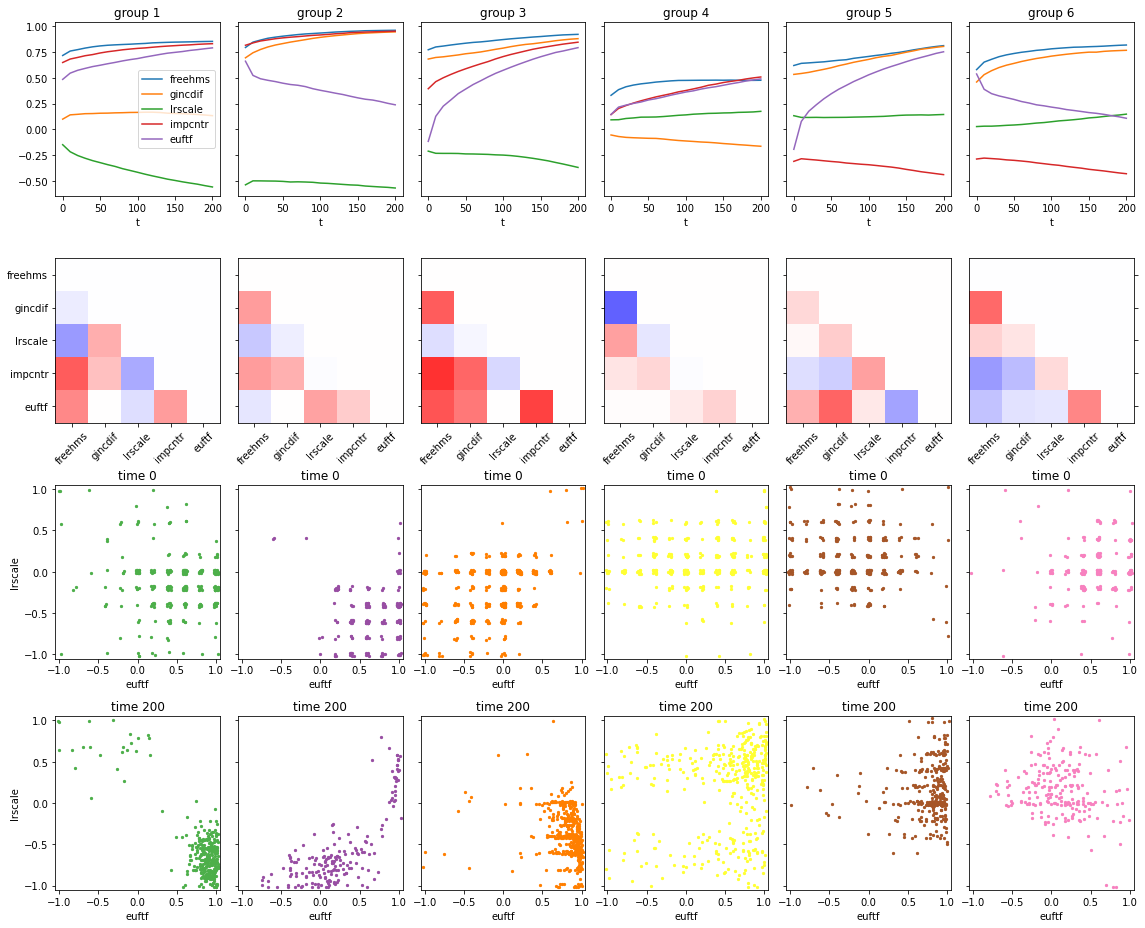

In [16]:
plot_before_after_hist(results_mix, T=T)
compare_states(results_mix, 0, T, "euftf", "lrscale")
plot_example_agents(results_mix, 10)
plot_group_dynamics(results_mix, params3, "euftf", "lrscale")


### mix of social-influence + self-check with smaller k 
- fixed network
- some social influence and self-coherence
- logistic function translating coherence change into probability of adaptation is quite flat

In [17]:
params4 = copy.copy(default_params)
params4["prob_social_influence"] = 0.5
params4["prob_self_check"] = 1
params4["variance_of_new_belief"] = 0.1
params4["k_coherence"] = 20
params4["k_link"] = -20


elapsed_time, results_mix_k20, results_network_mix_k20 = simulation(T, track_times, params4, verbose=False, save_network=True)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 


elapsed time: 1 min and 5.2 seconds (i.e. 0.3259000670909882 s per tick)


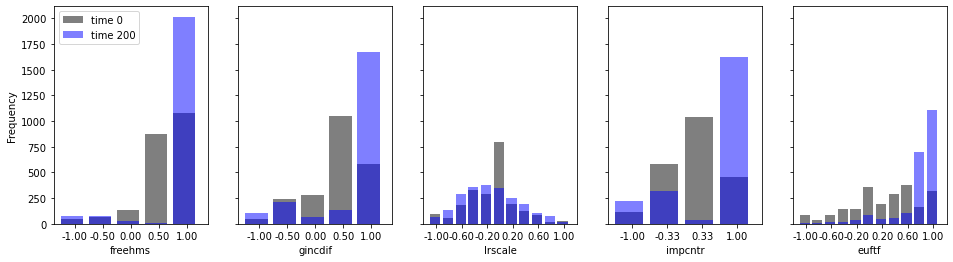

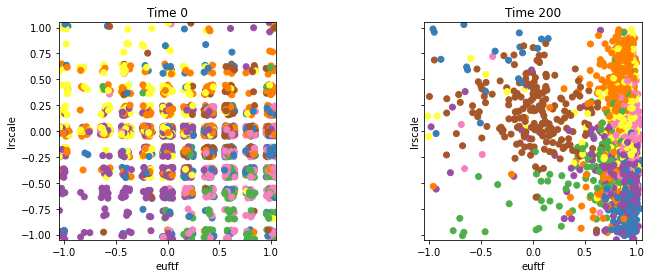

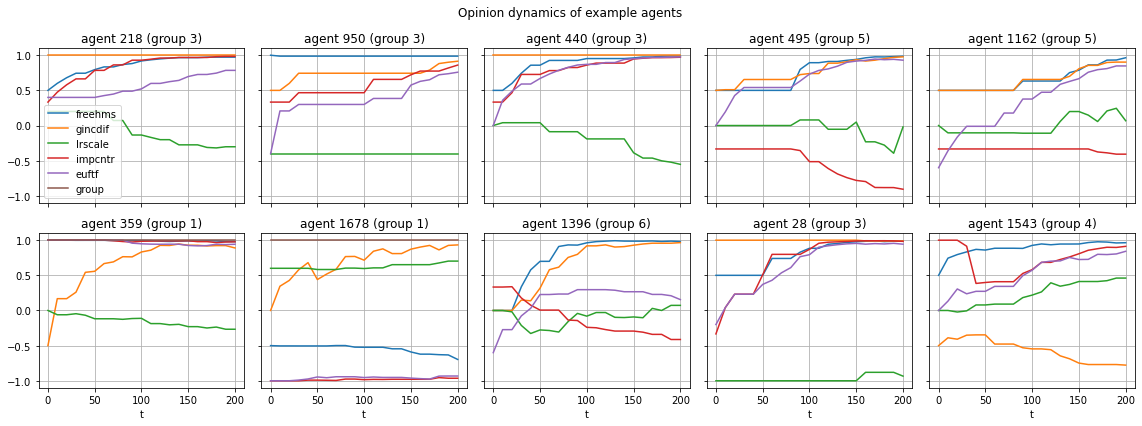

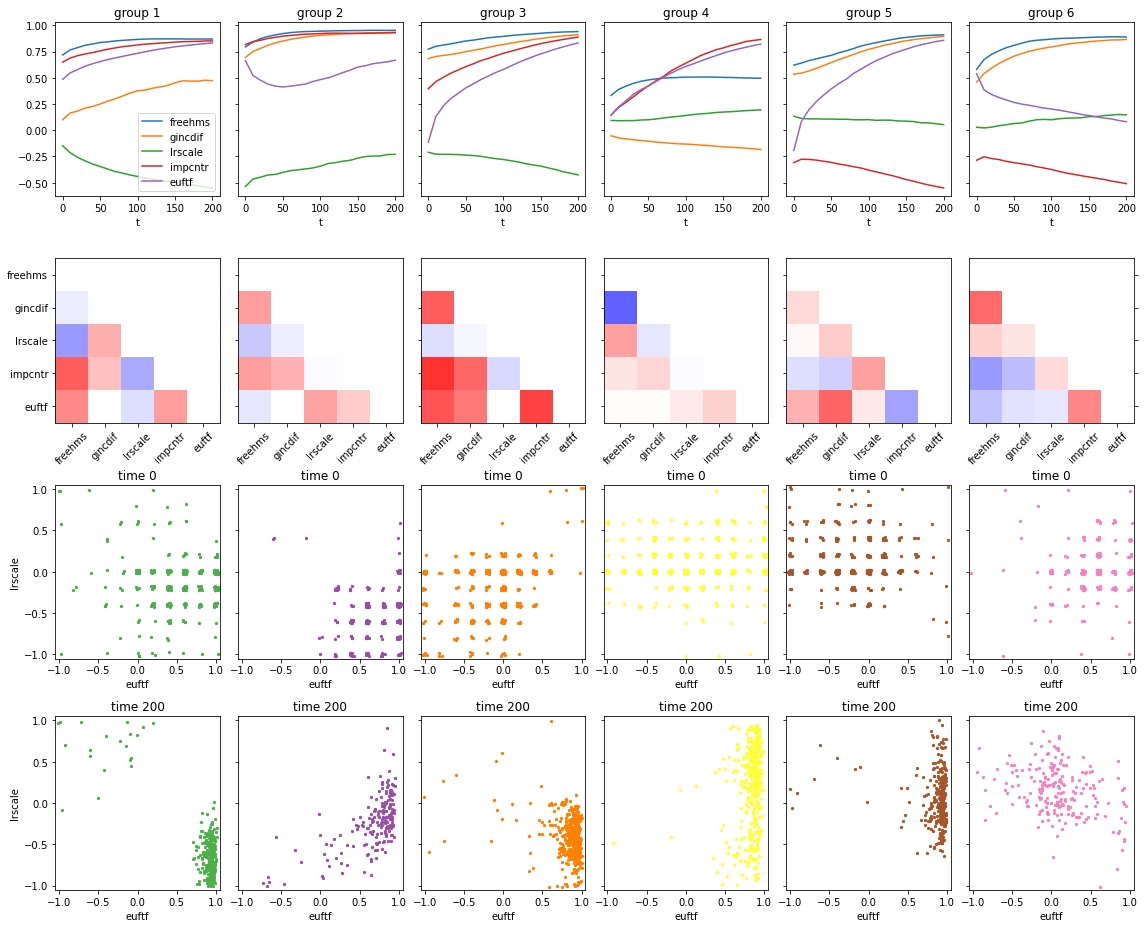

In [18]:
plot_before_after_hist(results_mix_k20, T=T)
compare_states(results_mix_k20, 0, T, "euftf", "lrscale")
plot_example_agents(results_mix_k20, 10)
plot_group_dynamics(results_mix_k20, params4, "euftf", "lrscale")


Text(0.5, 0, 'delta coherence')

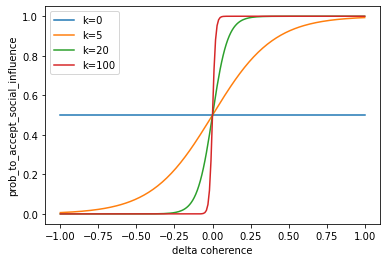

In [19]:
x = np.linspace(-1,1, 201)
plt.plot(x, logistic(x, 0), label="k=0")
plt.plot(x, logistic(x, 5), label="k=5")
plt.plot(x, logistic(x, params4["k_coherence"]), label="k={}".format(params4["k_coherence"]))
plt.plot(x, logistic(x, 100), label="k=100")
plt.legend()
plt.ylabel("prob_to_accept_social_influence")
plt.xlabel("delta coherence")

### Simulation with k=0
- fixed network
- some social influence and self-coherence
- logistic function translating coherence change into probability of adaptation is *completely* flat

In [20]:
params5 = copy.copy(default_params)
params5["prob_social_influence"] = 0.5
params5["prob_self_check"] = 1
params5["variance_of_new_belief"] = 0.1
params5["k_coherence"] = 0
params5["k_link"] = -0


elapsed_time, results_mix_k0, results_network_mix_k0 = simulation(T, track_times, params5, verbose=False, save_network=True)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 


elapsed time: 1 min and 8.5 seconds (i.e. 0.3426796555519104 s per tick)


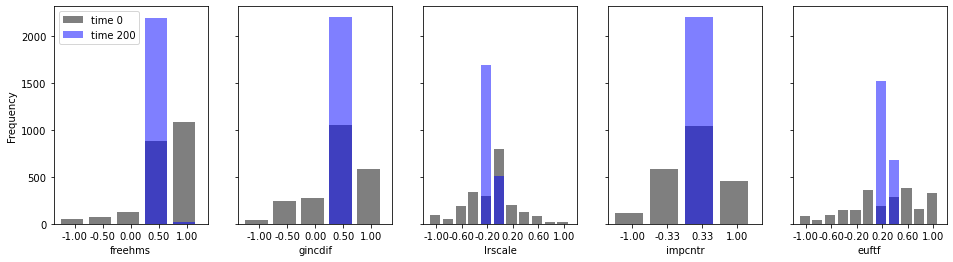

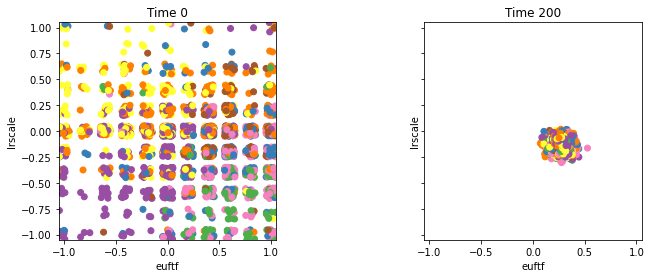

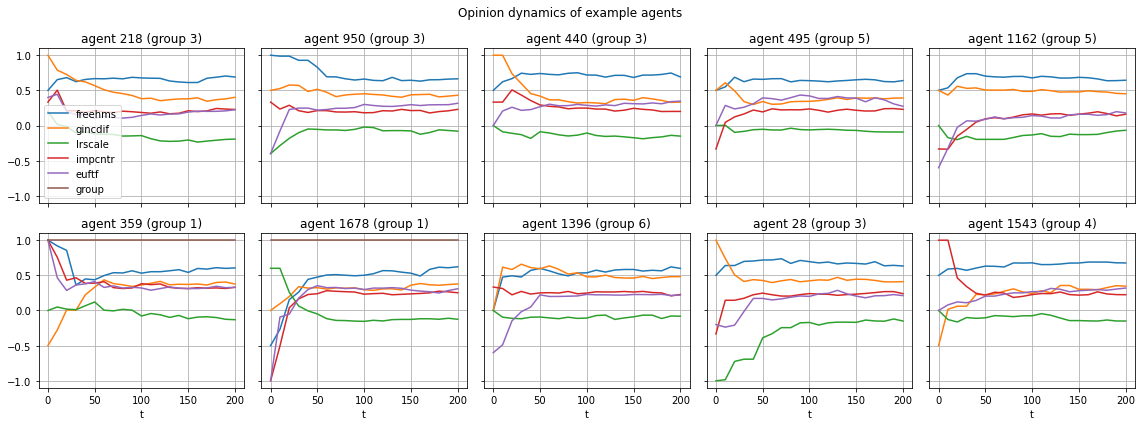

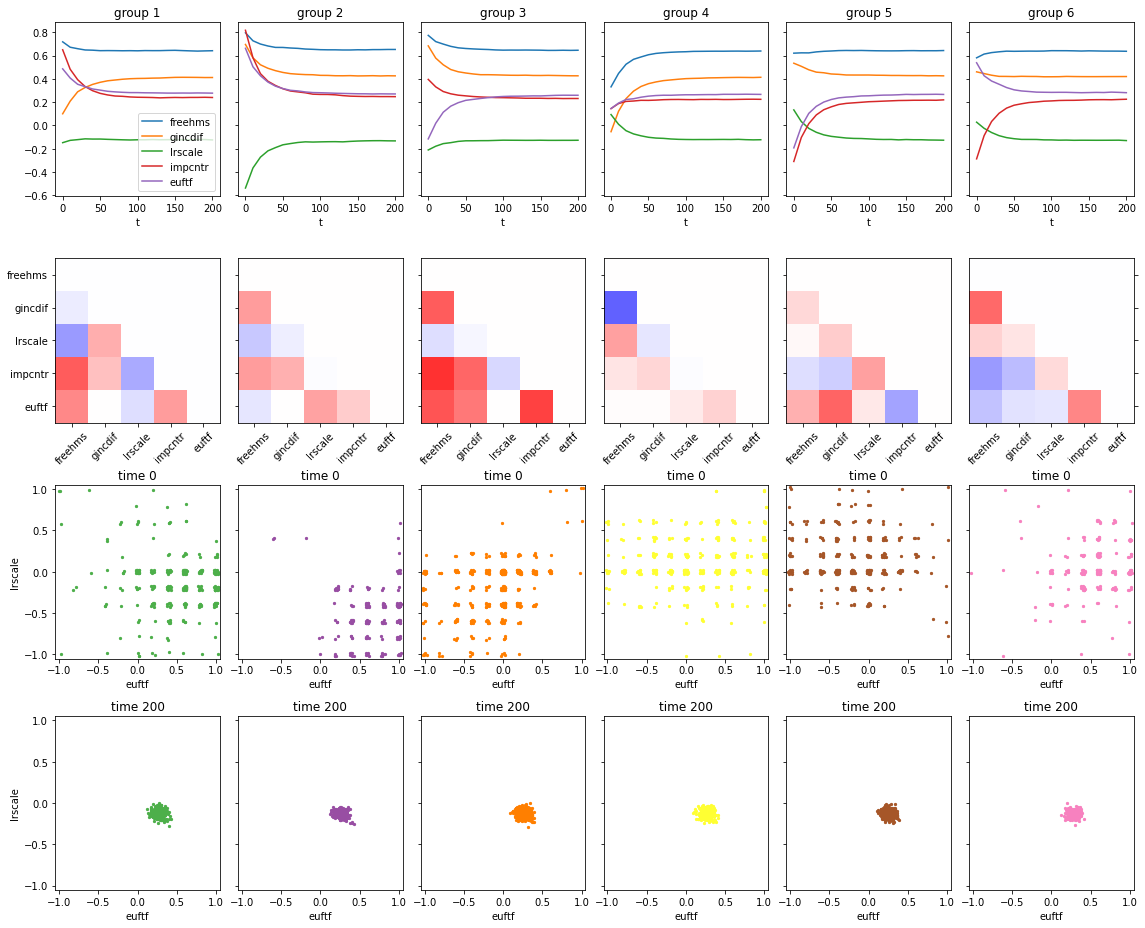

In [21]:
plot_before_after_hist(results_mix_k0, T=T)
compare_states(results_mix_k0, 0, T, "euftf", "lrscale")
plot_example_agents(results_mix_k0, 10)
plot_group_dynamics(results_mix_k0, params5, "euftf", "lrscale")


### Dynamic network
#### Normal simulation with k=100, some social influence and self-coherence.
- dynamic network: using _PS version
- some social influence and self-coherence
- logistic function translating coherence change into probability of adaptation with steep coherence

In [145]:
T = 1000
track_times = np.arange(0,T+1, 10)
params6 = copy.copy(default_params)
params6["prob_social_influence"] = 1.0
params6["prob_self_check"] = 0.5
params6["variance_of_new_belief"] = 0.1
params6["k_coherence"] = 100
params6["k_link"] = -5

params6["link_health_change"] = 0.4
params6["max_prob_drop_bad_link"] = 1.0
params6["prob_FoF"] = 0.0
params6["version"] = "coherence_MB_v2_BE_2.2_PS"
params6["link_lonely"] = False

elapsed_time, results_dynNet, results_network_dynNet = simulation(T, track_times, params6, verbose=True, save_network=True)
print("elapsed time: {:} min and {:.1f} seconds (i.e. {} s per tick)".format(elapsed_time[0], elapsed_time[1], (60*elapsed_time[0]+elapsed_time[1])/T )) 


Setup DONE
initial state saved, start running
10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, ...done
elapsed time: 8 min and 8.7 seconds (i.e. 0.4887035105228424 s per tick)


group: 1 --> #=304, group: 2 --> #=185, group: 3 --> #=422, group: 4 --> #=385, group: 5 --> #=325, group: 6 --> #=212, group: 7 --> #=370, group: 1 --> #=304, group: 2 --> #=185, group: 3 --> #=422, group: 4 --> #=385, group: 5 --> #=325, group: 6 --> #=212, group: 7 --> #=370, 

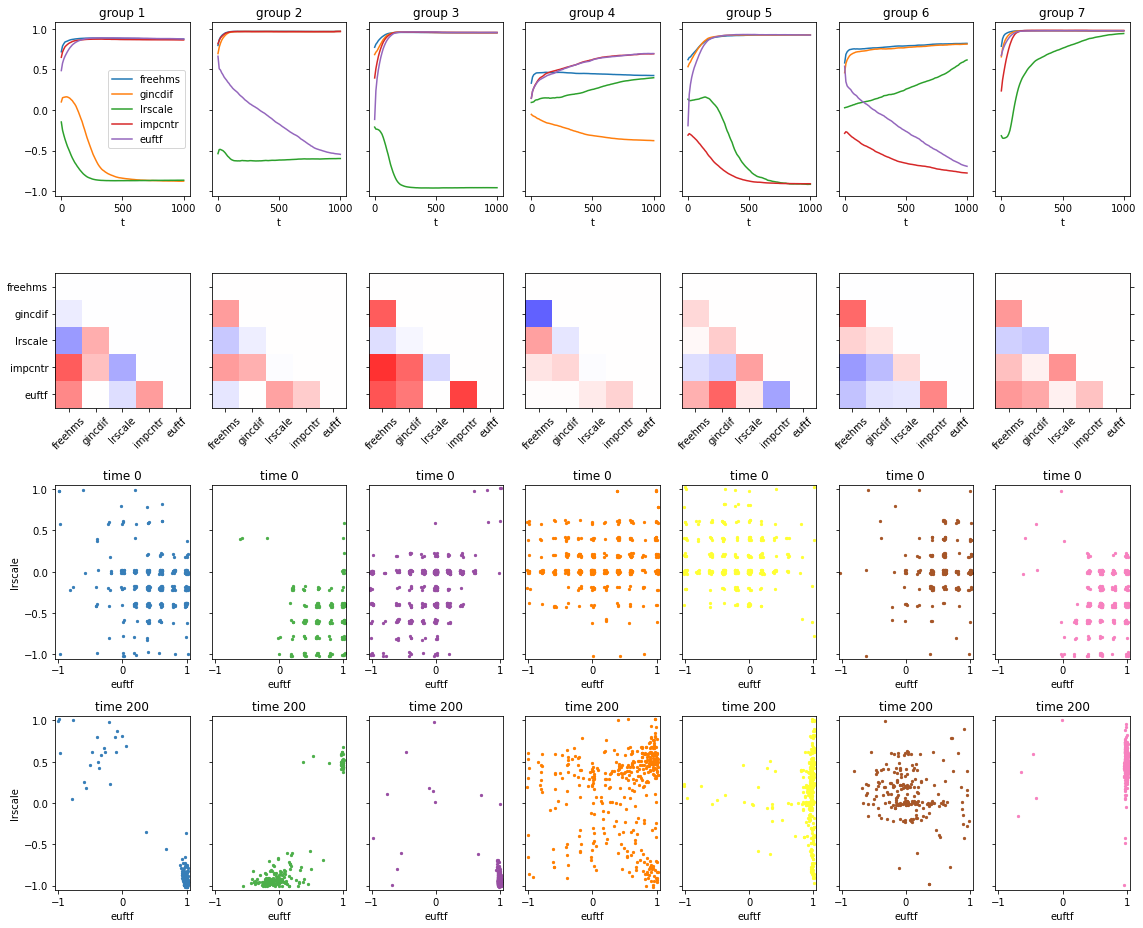

In [176]:
#plot_before_after_hist(results_dynNet, T=T)
#compare_states(results_dynNet, 0, T, "euftf", "lrscale")
#plot_example_agents(results_dynNet, 10)
groupcolourmapping = plot_group_dynamics(results_dynNet, params6, "euftf", "lrscale")
plt.savefig("test_dynamicnetwork.png")

### Analyse the dynamic run!

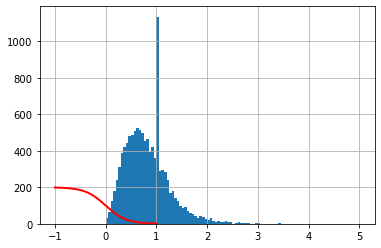

In [141]:
results_nw = results_network_dynNet
x = np.linspace(-1,1, 201)
results_nw.where(results_nw["t"]==10).dropna().health.drop(columns="t").hist(bins=np.linspace(0,5,101))
plt.plot(x, 200*logistic(x, params6["k_link"]), color="red", lw=2)

#### In the following I try to analyse whether group connections change. 
Nodes are one group (size = population in the group) and edges are links between them. In theory, I expect that there should be more internal links, beacuse these agents tend to be more coherent wiht their beliefs. But this may not be the case. There might be a group that disentangles entirely

In [156]:
n_agents = len(results_dynNet.loc[results_dynNet["t"]==t].dropna())
n_agents

2203

In [164]:
groups = list(groupcolourmapping.keys())
def get_group_edges(results_nw, results, t, verbose=False):
    a = results_nw.where(results_nw["t"]==t).dropna().drop(columns="t")
    n_edges = len(a)
    n_agents = len(results.loc[results["t"]==t].dropna())
    G = nx.Graph()
    b = results.where(results["t"]==t).dropna().drop(columns="t")
    G.add_nodes_from(list(range(len(b))))
    nx.set_node_attributes(G, dict(zip(G.nodes, b.group.to_numpy())),name="group")

    G2 = nx.from_pandas_edgelist(a, source="source", target="target", edge_attr="health")
    G.add_edges_from(G2.edges(data=True))
    print(len(G.nodes()), n_edges)
    internal_edges = []
    group_size = []
    for g in groups:
        g_nodes = [n for n in G.nodes() if G.nodes[n]["group"]==g]
        gsubgraph = G.subgraph(g_nodes)
        internal_edges.append(len(gsubgraph.edges))
        group_size.append(len(gsubgraph.nodes()))
        if verbose: print("Group {} has {} nodes and {} internal links: {:.3f}".format(g, len(gsubgraph.nodes()), len(gsubgraph.edges), len(gsubgraph.edges) / len(G.edges)))
    betweenlinks = []
    betweenlinksdict = {}
    for n, g in enumerate(groups):
        for n2, g2 in enumerate(groups[:n+1]):
            g_nodes = [n for n in G.nodes() if G.nodes[n]["group"]==g or G.nodes[n]["group"]==g2]
            gsubgraph = G.subgraph(g_nodes)
            if verbose: print("Groups {} and {} have {} links between them".format(g, g2, len(gsubgraph.edges)-internal_edges[n] - internal_edges[n2]))
            betweenlinks.append(len(gsubgraph.edges)-internal_edges[n] - internal_edges[n2])
            betweenlinksdict[(g, g2)] = len(gsubgraph.edges)-internal_edges[n] - internal_edges[n2]
    return betweenlinksdict, group_size

def draw_group_graph(betweenlinksdict, group_size, pos=None, diff=False):   
    groupG = nx.Graph()
    for n, g in enumerate(groups):
        groupG.add_node(g)
        nx.set_node_attributes(groupG, dict(zip(groups, group_size)), name="size")
    nodelist = list(groupG.nodes())
    for n1,g1 in enumerate(groups):
        for n2,g2 in enumerate(groups[:n1+1]):
            groupG.add_edge(g1, g2, weight=betweenlinksdict[(g1,g2)])
    if pos is None:
        pos = nx.circular_layout(groupG)
    cols = [groupcolourmapping[k] for k in groupG.nodes()]
    if diff:
        edge_cols = ["blue" if groupG[u][v]['weight']<0  else "red" for u,v in groupG.edges() ]
        scale=0.01
    else:
        edge_cols="blue"
        scale=0.01
    sizes = np.array(list(nx.get_node_attributes(groupG, "size").values()))
    nx.draw(groupG, pos, node_size=2*sizes, 
            edge_color=edge_cols, 
            width = [scale * groupG[u][v]['weight'] for u,v in groupG.edges()], with_labels=False, node_color=cols)
    labels = dict(zip(groupG.nodes(), ["{}".format(n) for g,n in zip(groupG.nodes(), sizes)]))
    nx.draw_networkx_labels(groupG, pos, labels, font_color="k", font_size=12)

    return pos, groupG

    

In [166]:
t = 0
betweenlinksdict, group_size = get_group_edges(results_network_dynNet, results_dynNet, t, verbose=False)
print(group_size)
t = 1000
betweenlinksdictT, group_sizeT = get_group_edges(results_network_dynNet, results_dynNet, t, verbose=False)


2203 11015
[304, 185, 422, 385, 325, 212, 370]
2203 11015


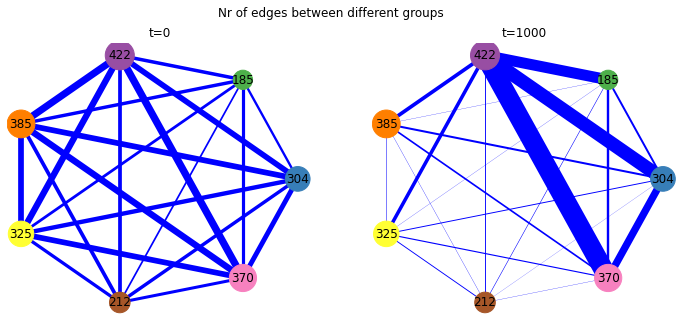

In [178]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
pos, groupG =  draw_group_graph(betweenlinksdict, group_size, None, diff=False)
plt.title("t=0")
fig.add_subplot(122)
pos, groupG =  draw_group_graph(betweenlinksdictT, group_sizeT, pos, diff=False)
plt.title("t=1000")
fig.suptitle("Nr of edges between different groups")
plt.savefig("test_dynamicnetwork_betweengroups.png")

red means links between the groups have reduced, blue means links have increased


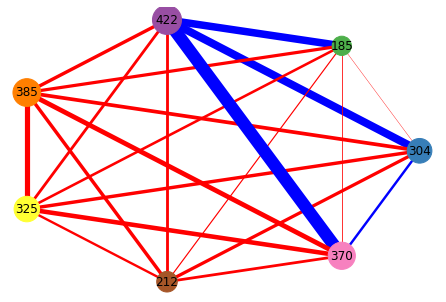

In [167]:
diffBetw = dict(zip(betweenlinksdict.keys(), [betweenlinksdict[a] - betweenlinksdictT[a] for a in betweenlinksdict.keys()]))
pos, groupG =  draw_group_graph(diffBetw, group_size, None, diff=True)
print("red means links between the groups have reduced, blue means links have increased")

In [144]:
sames ={}
diffs = {}
for a in betweenlinksdict.keys():
    if a[0]==a[1]:
        sames[a] = betweenlinksdict[a] - betweenlinksdictT[a]
    else:
        diffs[a] = betweenlinksdict[a] - betweenlinksdictT[a]
        
print(sames)
print(diffs)
print("The change in internal links: ", sum(list(sames.values())), " and the change in between group links", sum(list(diffs.values())))

{(1, 1): 7, (2, 2): 12, (3, 3): -23, (4, 4): 54, (5, 5): 20, (6, 6): 33, (7, 7): -3}
{(2, 1): -9, (3, 1): -81, (3, 2): -20, (4, 1): -53, (4, 2): -19, (4, 3): -102, (5, 1): -100, (5, 2): -74, (5, 3): -50, (5, 4): -136, (6, 1): -39, (6, 2): -17, (6, 3): -26, (6, 4): -15, (6, 5): -116, (7, 1): -82, (7, 2): 8, (7, 3): -29, (7, 4): -55, (7, 5): -78, (7, 6): -87}
The change in internal links:  100  and the change in between group links -1180


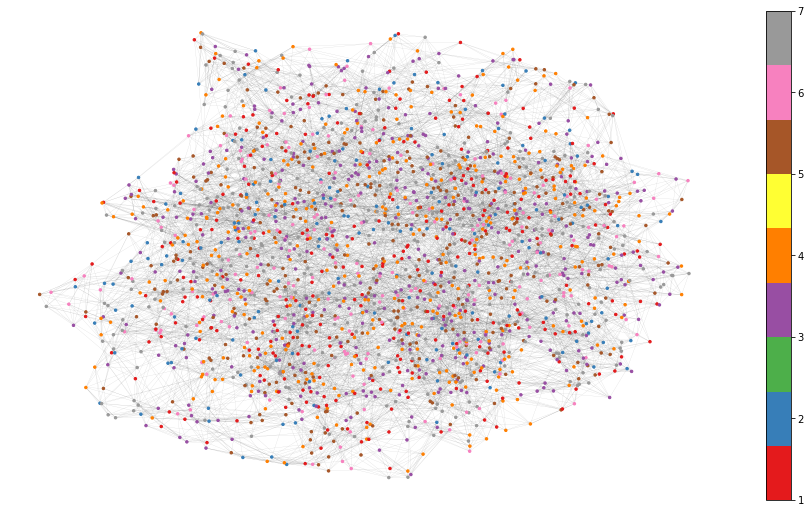

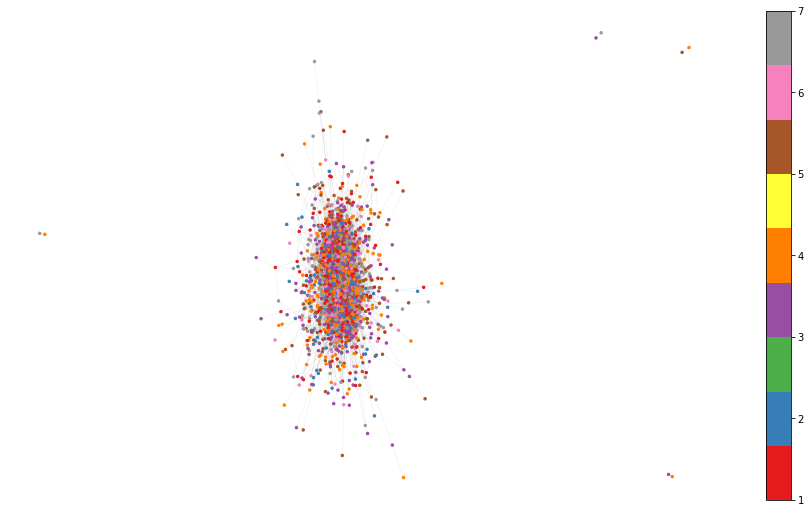

In [79]:
# RUN THIS ONLY IF YOU HAVE SOME TIME
#pos = vis_network(results_network_dynNet, results_dynNet, 0)
p=vis_network(results_network_dynNet, results_dynNet, 0, pos = None)
p=vis_network(results_network_dynNet, results_dynNet, T, pos = None)

# TESTS

### Check how fast this runs and where the code spends most of its time

In [ ]:
import cProfile
import pstats
params = dict(
        rand_seed=42, 
        network_type = "watts",
        network_params={"rewiring_prob":0.1, "avg_node_degree":10}, 
        country="DE",
        n_attitudes = 5,
        k_coherence=100,
        k_link=-100, 
        conformity_tendency = 0.3,
        variance_of_new_belief = 0.0,
        prob_social_influence = 1.0 ,
        prob_self_check = 0.0,
        link_health_change = 0.0,
        max_prob_drop_bad_link = 0.0,
        prob_FoF = 0.0,
        version = "coherence_MB_v2_BE_2.2",
        prob_add_link = 0.0,
        link_lonely = False,
        max_num_links = 100,
        init_beliefs="from_data",
)
with cProfile.Profile() as pr:
        elapsed_time, results, results_network = simulation(100, np.arange(0,100,step=10), params, verbose=True, save_network=True)
        #elapsed_time, results = simulation(T, track_times, params)
        print("elapsed time: {:} min and {:.1f} seconds".format(elapsed_time[0], elapsed_time[1])) 

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
# Now you have two options, either print the data or save it as a file
stats.print_stats() # Print The Stats
#stats.dump_stats("cprofile.prof")

### Matrices 

1.1348423827034897
1.2706901172940208
3.6626737470789914
0.2012118238377396
1.0888781837559467
0.3736972130321269


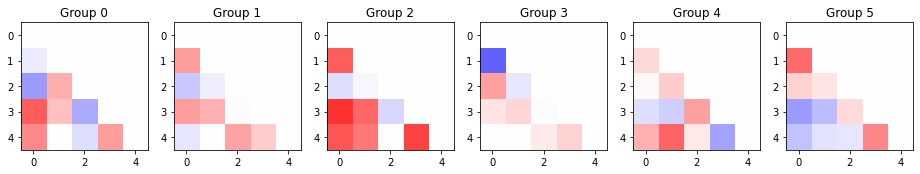

In [67]:
m = Model(**default_params, save_network=False)
fig, axes = plt.subplots(1,6, figsize=(16,3))
for n, ax in enumerate(axes):
    ax.imshow(np.tril(m.matrix_list[n]), vmin=-1, vmax=1,cmap="bwr")
    ax.set_title("Group {}".format(n))
    print(0.5* m.matrix_list[n].to_numpy().sum())